In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
#import pytz
import scipy
import requests
import warnings
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)

import extract_nba_rolling_stats

# Parameters and Data

In [2]:
eda_rolling_period = 15
eda_stat_cats = ['fpts']

In [3]:
# Use script to get data
extract = extract_nba_rolling_stats.run_extract(roll_period = eda_rolling_period,
                                                    categories = eda_stat_cats)

Calculating stats for ['fpts']
Reading in Stats
Reading in Games
Reading in Players
Calculating individual team rolling statistics...
Shifting data...
Calculating league team rolling statistics...
Shifting data...
Calculating individual player rolling statistics...
Shifting data...
Calculating league player rolling statistics...
Shifting data...
Merging all data...
Standardizing data...
Done!


In [4]:
extracted_data = extract.extracted_data
standardized_data = extract.standardized_data

In [5]:
players = extract_nba_rolling_stats.NBAData('Players').data()

Reading in Players


In [6]:
players[players['player_full_name'].str.contains('Luka')]

,player_team_id,player_position,player_full_name,player_first_name,player_last_name,player_height_feet,player_height_inches,player_weight_pounds
player_id,,,,,,,,
17896056,18,C,Luka Garza,Luka,Garza,NaN,NaN,NaN
132,7,G-F,Luka Doncic,Luka,Doncic,6.0,7.0,218.0
666881,29,F,Luka Samanic,Luka,Samanic,NaN,NaN,NaN


In [7]:
nonzero = standardized_data#[standardized_data['pts'] != 0]

# EDA

## Normalize Stats

0.7034522588630063


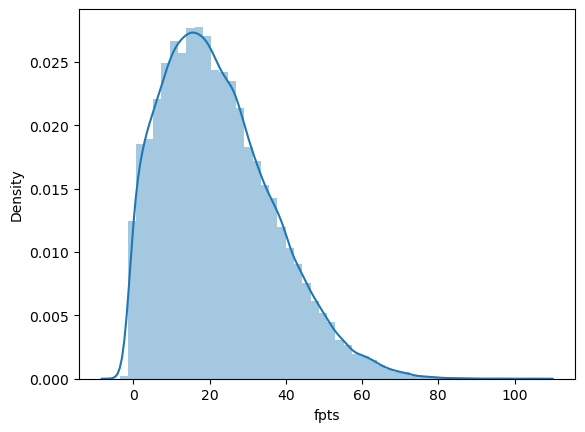

In [9]:
_ = sns.distplot(nonzero['fpts'])
print((nonzero['fpts']).skew())

-0.9843290788999889


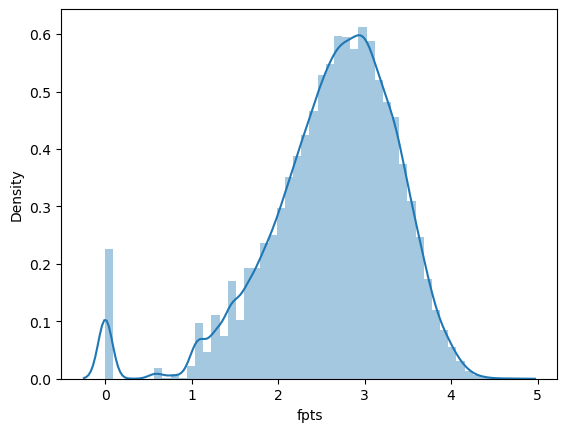

In [10]:
_ = sns.distplot((nonzero['fpts'])**(1/3))
print(((nonzero['fpts'])**(1/3)).skew())

-0.2898228265319186


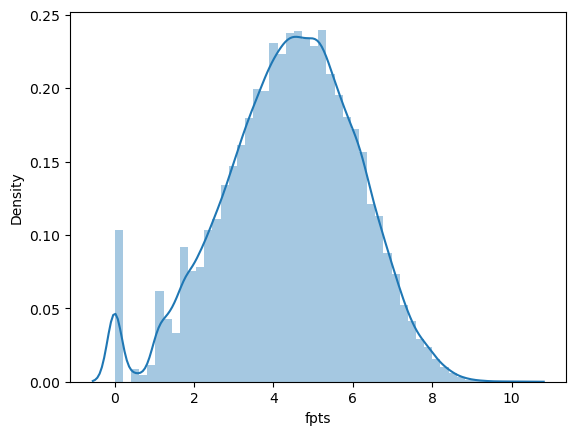

In [11]:
_ = sns.distplot((nonzero['fpts'])**(1/2))
print(((nonzero['fpts'])**(1/2)).skew())

In [12]:
for cat in eda_stat_cats:
    nonzero[cat+'_normed'] = nonzero[cat].apply(lambda x: (x**(1/2)).real)

## Remove Outliers

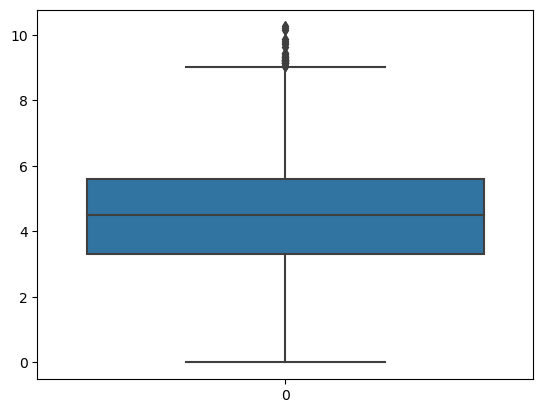

In [13]:
_ = sns.boxplot(nonzero['fpts_normed'])

In [14]:
third_quart = np.percentile(nonzero[(nonzero['fpts_normed'] > 0)]['fpts_normed'], 75, method='midpoint')
first_quart = np.percentile(nonzero[(nonzero['fpts_normed'] > 0)]['fpts_normed'], 25, method='midpoint')

In [15]:
interquartile_range = third_quart - first_quart

upper = third_quart + (1.5*interquartile_range)
lower = first_quart - (1.5*interquartile_range)

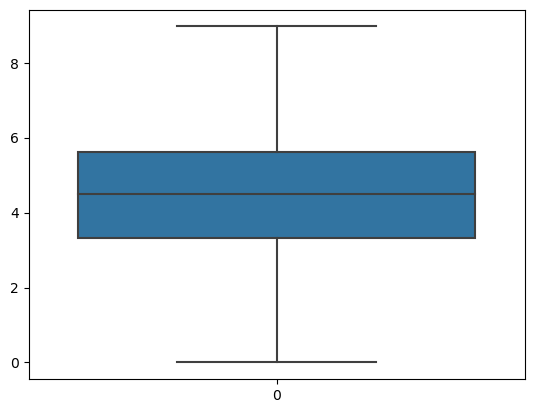

In [16]:
_ = sns.boxplot(nonzero[(nonzero['fpts_normed'] <= upper)
                    # & (nonzero['fpts_normed'] > 0)
                ]['fpts_normed'])

In [17]:
no_outliers = nonzero[(nonzero['fpts_normed'] <= upper)]

## Normalize Minutes?

-0.29801382312947733


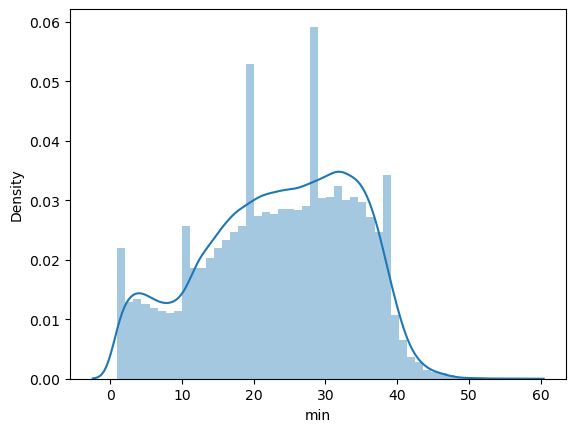

In [18]:
_ = sns.distplot(no_outliers['min'])
print((no_outliers['min']).skew())

In [9]:
from sklearn.preprocessing import StandardScaler

In [26]:
no_outliers['min_stand'] = no_outliers['min'].apply(lambda x: (x - no_outliers['min'].mean())/(no_outliers['min'].std()))

-0.2980138231294774


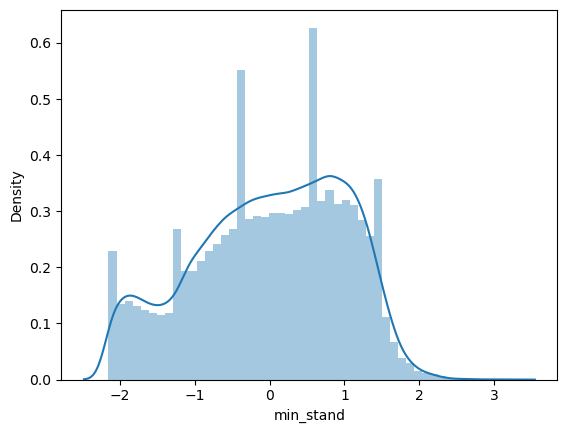

In [27]:
_ = sns.distplot(no_outliers['min_stand'])
print((no_outliers['min_stand']).skew())

In [10]:
scaler = StandardScaler()

In [15]:
scaled = scaler.fit_transform(nonzero.set_index('game_date')[['opponent_team_opp_pos_fpts_pg',
                               'fpts']])

## Flag for Meeting Average

In [8]:
for cat in eda_stat_cats:
    no_outliers[cat+'_avg_met'] = (no_outliers['fpts'] >= no_outliers['player_fpts_mean']).apply(int)

NameError: name 'no_outliers' is not defined

## Normalize Opponent Stats?

In [34]:
opp_stats = no_outliers[['game_date','player_position',
             'opponent_team_id','opponent_team_opp_fpts_pg',
             'league_opp_fpts_pg_mean','league_opp_fpts_pg_std',
             'opponent_team_opp_fpts_pg_stand',
                        'fpts_avg_met']]

In [35]:
opp_stats_g = opp_stats[opp_stats['player_position'] == 'G']
opp_stats_gf = opp_stats[opp_stats['player_position'] == 'G-F']
opp_stats_f = opp_stats[opp_stats['player_position'] == 'F']
opp_stats_fc = opp_stats[opp_stats['player_position'] == 'F-C']
opp_stats_c = opp_stats[opp_stats['player_position'] == 'C']
opp_stats_unk = opp_stats[opp_stats['player_position'] == 'UNK']

0.14568229312122763


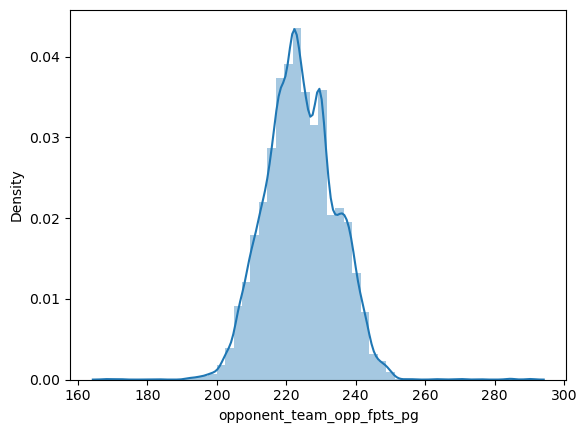

In [36]:
_ = sns.distplot((opp_stats_g['opponent_team_opp_fpts_pg']))
print(((opp_stats_g['opponent_team_opp_fpts_pg'])).skew())

-1.2428312221476217


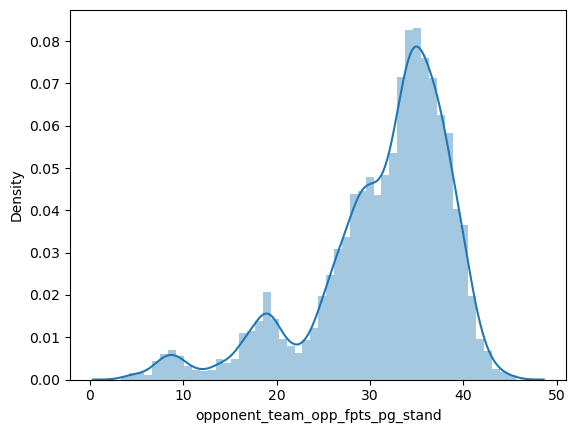

In [37]:
_ = sns.distplot((opp_stats_f['opponent_team_opp_fpts_pg_stand']))
print(((opp_stats_f['opponent_team_opp_fpts_pg_stand'])).skew())

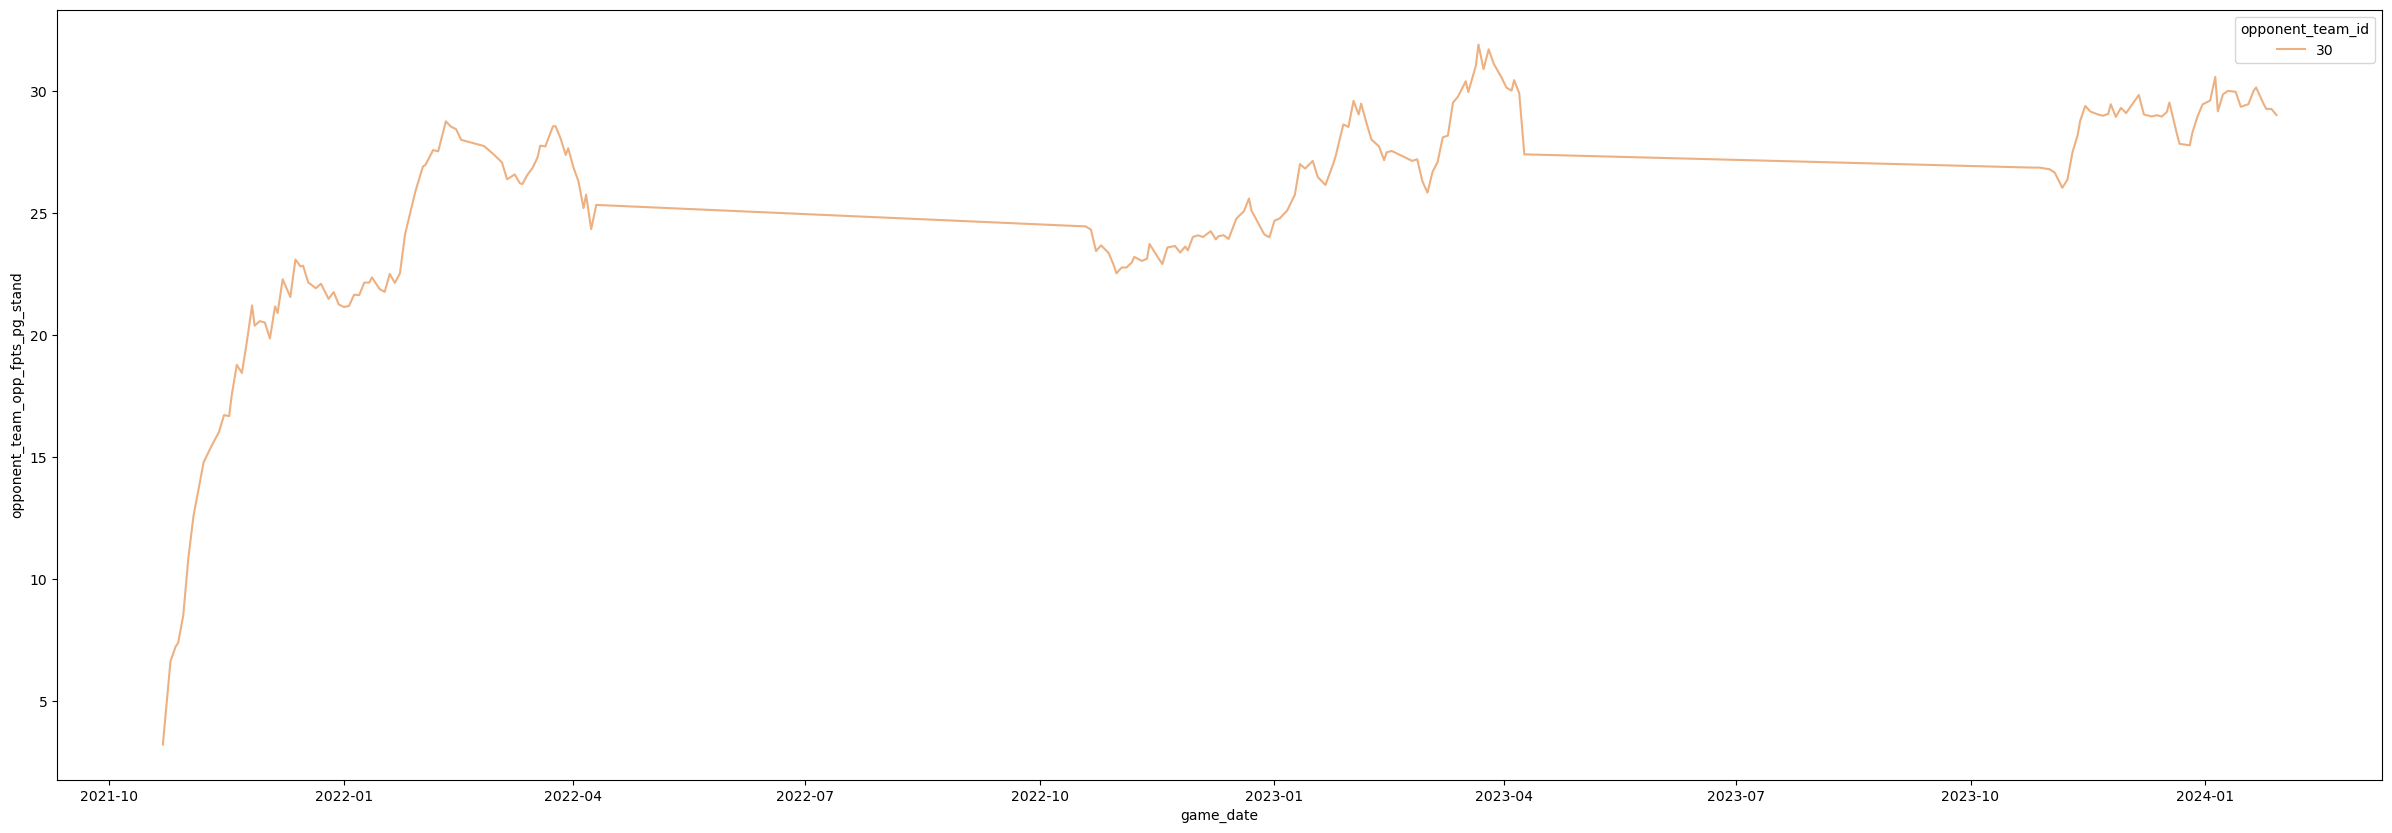

In [38]:
fig, ax = plt.subplots(figsize = (30,10))
_ = sns.lineplot(data = opp_stats_g[opp_stats_g['opponent_team_id'] == 30]\
                             .drop_duplicates(['game_date','opponent_team_id',
                                             'opponent_team_opp_fpts_pg_stand']),
                 x = 'game_date',
                 y = 'opponent_team_opp_fpts_pg_stand',
                 hue = 'opponent_team_id',
                palette = 'flare')

In [39]:
team30_stats = opp_stats_g[opp_stats_g['opponent_team_id'] == 30]\
                             .drop_duplicates(['game_date','opponent_team_id',
                                             'opponent_team_opp_fpts_pg_stand'])

In [40]:
team30_stats[team30_stats['opponent_team_opp_fpts_pg_stand'] == team30_stats['opponent_team_opp_fpts_pg_stand'].max()]

,game_date,player_position,opponent_team_id,opponent_team_opp_fpts_pg,league_opp_fpts_pg_mean,league_opp_fpts_pg_std,opponent_team_opp_fpts_pg_stand,fpts_avg_met
45970,2023-03-22,G,30,225.717143,93.614286,4.139021,31.91645,1


In [41]:
opp_stats_g[opp_stats_g['game_date'] <= '2022-01-15'].drop_duplicates(['opponent_team_id'],
                                                                      keep = 'last')['opponent_team_opp_fpts_pg'].describe()

count     30.000000
mean     219.115261
std        8.064534
min      205.834884
25%      213.454281
50%      218.589535
75%      224.707973
max      239.026190
Name: opponent_team_opp_fpts_pg, dtype: float64

## Dummify Player Position

In [42]:
data_dummied = pd.get_dummies(data = no_outliers,
                              columns= ['player_position'],
                              dtype = int)

## Correlation Plots

### Full Set

In [43]:
data_dummied['fpts_mean_stand'] = (data_dummied['player_fpts_mean'] - data_dummied['fpts_mean_mean'])/data_dummied['fpts_mean_std']

In [44]:
data_dummied.columns

Index(['game_date', 'player_id', 'team_id', 'opponent_team_id', 'min', 'fpts',
       'player_fpts_per36', 'player_fpts_mean', 'player_avg_min',
       'league_player_fpts_per36_mean', 'league_player_fpts_per36_std',
       'fpts_mean_mean', 'fpts_mean_std', 'team_fpts_pg',
       'league_fpts_pg_mean', 'league_fpts_pg_std',
       'opponent_team_opp_fpts_pg', 'league_opp_fpts_pg_mean',
       'league_opp_fpts_pg_std', 'team_fpts_pg_stand',
       'opponent_team_opp_fpts_pg_stand', 'player_fpts_per36_stand',
       'fpts_mean_stand', 'fpts_normed', 'fpts_avg_met', 'player_position_C',
       'player_position_F', 'player_position_F-C', 'player_position_G',
       'player_position_G-F', 'player_position_UNK'],
      dtype='object')

In [45]:
data_fpts_rel = data_dummied[['game_date','team_id','opponent_team_id',
                    'player_id','player_avg_min',
                    # 'player_position_G','player_position_G-F',
                    # 'player_position_F','player_position_F-C',
                    # 'player_position_C','player_position_UNK',
                    'min','fpts','fpts_normed',
                    'player_fpts_per36','player_fpts_mean',
                              'fpts_mean_mean',
                              'team_fpts_pg','league_fpts_pg_mean',
                              'opponent_team_opp_fpts_pg','league_opp_fpts_pg_mean',
                    'player_fpts_per36_stand','fpts_mean_stand',
                    'team_fpts_pg_stand','opponent_team_opp_fpts_pg_stand',
                             'fpts_avg_met']]

# [data_dummied['player_id'] == 231]

In [46]:
# plot opponent pts and pts_normed
## Get difference in pts from average points
data_fpts_rel['fpts_diff_from_avg'] = data_fpts_rel['fpts'] - data_fpts_rel['player_fpts_mean']

## Get difference in defensive and offensive ability
data_fpts_rel['fpts_off_def_diff'] = data_fpts_rel['team_fpts_pg_stand'] - data_fpts_rel['opponent_team_opp_fpts_pg_stand']

In [20]:
scaled_df = pd.DataFrame(scaled).dropna()

In [21]:
fpts_corr = scaled_df\
            .corr()

fpts_corr.style\
        .background_gradient(cmap = 'coolwarm',
                            axis = None,
                            vmin = -1,
                            vmax = 1)\
        .highlight_null('#f1f1f1')\
        .format(precision = 2)

,0,1
0,1.00,-0.01
1,-0.01,1.00


### No Opponent Correlation

In [27]:
data_fpts_rel.head()

,game_date,team_id,opponent_team_id,player_id,player_avg_min,min,fpts,fpts_normed,player_fpts_per36,player_fpts_mean,fpts_mean_mean,team_fpts_pg,league_fpts_pg_mean,opponent_team_opp_fpts_pg,league_opp_fpts_pg_mean,player_fpts_per36_stand,fpts_mean_stand,team_fpts_pg_stand,opponent_team_opp_fpts_pg_stand
0,2021-10-19,3,17,6,NaN,16.0,8.1,2.846050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-10-19,17,3,8,NaN,28.0,29.8,5.458938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-10-19,17,3,15,NaN,31.0,64.3,8.018728,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-10-19,14,10,17,NaN,26.0,15.8,3.974921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-10-19,14,10,36,NaN,31.0,12.4,3.521363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


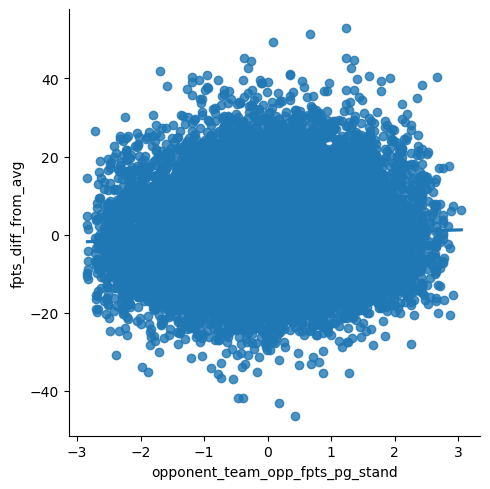

In [34]:
_ = sns.lmplot(data = data_fpts_rel[data_fpts_rel['game_date'] >= '2023-01-01'],
                    x = 'opponent_team_opp_fpts_pg_stand',
                    y = 'fpts_diff_from_avg')

# [data_fpts_rel['player_id'] == 132]

### Observations

- Opposing defense against a position does not seem to be correlated to a players point output
- Possible correlation between minutes, a players points per 36 minutes and the teams offensive output for a given position

In [77]:
data_dummied[(data_dummied['opponent_team_id'] == 3)
                & (data_dummied['player_position_G'] == 1)
            ].groupby(['game_date'])[['fpts']].sum()

,fpts
game_date,
2021-10-19,96.6
2021-10-22,60.2
2021-10-24,65.3
2021-10-25,93.7
2021-10-27,57.5
...,...
2024-01-21,130.1
2024-01-23,99.5
2024-01-25,71.8


In [80]:
data_dummied[(data_dummied['opponent_team_id'] == 3)
                & (data_dummied['player_position_G'] == 1)
            ].drop_duplicates(['game_date','opponent_team_id'])

,game_date,player_id,team_id,opponent_team_id,min,fpts,player_fpts_per36,player_fpts_mean,player_avg_min,league_player_fpts_per36_mean,league_player_fpts_per36_std,fpts_mean_mean,fpts_mean_std,team_fpts_pg,league_fpts_pg_mean,league_fpts_pg_std,opponent_team_opp_fpts_pg,league_opp_fpts_pg_mean,league_opp_fpts_pg_std,team_fpts_pg_stand,opponent_team_opp_fpts_pg_stand,player_fpts_per36_stand,fpts_normed,player_position_C,player_position_F,player_position_F-C,player_position_G,player_position_G-F,player_position_UNK
1,2021-10-19,8,17,3,28.0,29.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.458938,0,0,0,1,0,0
346,2021-10-22,114,23,3,36.0,36.8,17.228571,13.400000,28.000000,32.299519,12.889546,23.965385,13.604954,52.700000,92.618333,31.122152,96.600000,92.653333,30.949634,-1.282634,0.127519,-1.169238,6.066300,0,0,0,1,0,0
724,2021-10-24,422,4,3,21.0,30.8,40.523077,21.950000,19.500000,33.131985,11.507519,24.021622,13.152548,76.600000,90.063889,26.283179,78.400000,92.146111,19.785501,-0.512263,-0.694757,0.642284,5.549775,0,0,0,1,0,0
782,2021-10-25,37,30,3,32.0,23.6,42.988235,40.600000,34.000000,32.418427,10.104757,22.930488,11.709551,108.250000,90.157778,25.237009,74.033333,91.217778,18.911571,0.716893,-0.908674,1.046023,4.857983,0,0,0,1,0,0
1123,2021-10-27,286,16,3,34.0,26.7,28.538182,21.800000,27.500000,32.876476,10.357906,22.827669,11.598720,66.566667,90.711667,24.670574,78.950000,90.534167,17.260861,-0.978696,-0.671123,-0.418839,5.167204,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62633,2024-01-21,192,13,3,39.0,50.0,41.962654,41.079032,35.241935,31.733010,9.421779,20.212135,11.510560,84.304839,94.754785,23.006672,97.309677,94.784516,5.189093,-0.454214,0.486629,1.085744,7.071068,0,0,0,1,0,0
62899,2024-01-23,73,20,3,36.0,37.6,41.936050,41.954839,36.016129,31.430882,7.947283,20.166619,11.450464,115.840323,94.620376,23.062112,97.324194,94.633817,5.298581,0.920122,0.507754,1.321857,6.131884,0,0,0,1,0,0
63197,2024-01-25,104,18,3,33.0,26.4,32.619417,27.095161,29.903226,31.737125,7.603878,20.601098,11.367031,91.645161,94.531774,23.131799,96.996774,94.534624,5.322558,-0.124790,0.462588,0.116032,5.138093,0,0,0,1,0,0
63554,2024-01-27,213,11,3,18.0,9.1,27.024161,10.824194,14.419355,31.472573,6.713402,20.977808,10.952557,79.806452,94.397419,23.180825,96.970968,94.404355,5.424144,-0.629441,0.473183,-0.662617,3.016621,0,0,0,1,0,0


## Overtime Games

In [ ]:
games[games['game_period'] > 4]

# Extra

In [ ]:
games['game_period'].value_counts()